In [ ]:
import requests

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


# **Data Preprocessing**

In [ ]:
# Imports for data preprocessing
import re
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np


In [ ]:

"""
Cleans and tokenizes lines from a given text file into a list of words for each line.
"""
def data_preprocess1(filepath):
    processed_seqs = []

    with open(filepath) as f:
        lines = f.readlines()
        for seq in lines:
            # Tokenize each sequence
            words = seq.lower().split()
            # Remove lines that contain only one char (a number)
            if len(words) == 1:
                continue
            # Keep everything except apostrophe, hypthen, words, and whitespace
            words = [re.sub('[^\'\-\w\s]', '', w) for w in words]
            # Remove empty strings
            words = [word for word in words if word]
            # Append non-empty lists
            if words:
                processed_seqs.append(words)

    return processed_seqs


"""
Directly process entire text file into a single cleaned and flattened string.
"""
def data_preprocess2(filepath):
  # Read and process text file
  with open(filepath) as f:
      text = f.read().lower()
      # Keep everything except apostrophe, hypthen, words, and whitespace
      text = re.sub('[^\'\-\w\s]', '', text)
      # Remove numbers (of stanzas)
      text = re.sub(r'\d+', '', text)
      # Split the text into words
      words = text.split()
      # Get rid of empty strings
      words = [word for word in words if word]
      # Join the words back to text
      processed_text = ' '.join(words)
  return processed_text



In [ ]:
processed_seqs = data_preprocess1('shakespeare.txt')
processed_text = data_preprocess2('shakespeare.txt')

In [ ]:
char_seqs = []
seq_length = 40
step_size = 1 # Step size of 1 captures max context and variability in character patterns in the text

# Generate character sequences
for i in range(0, len(processed_text) - seq_length, step_size):
    sequence = processed_text[i:i + seq_length + 1] # Sliding window (41 for prediction)
    char_seqs.append(sequence)

print('There are {} 40-character sequences in shakespeare.txt given as input to the RNN'.format(len(char_seqs)))


There are 90965 40-character sequences in shakespeare.txt given as input to the RNN


In [ ]:
# Characters processing
unique_chars = sorted(list(set(processed_text)))
char_to_index = dict((char, idx) for idx, char in enumerate(unique_chars))
index_to_char = dict((idx, char) for idx, char in enumerate(unique_chars))
pickle.dump(char_to_index, open("char_to_index.pkl", "wb")) # Maps each char to an integer index for converting text data into a numerical format for LSTM
print('All the unique characters after processing in shakespeare.txt: ')
print(unique_chars)
print('Length: {}'.format(len(char_to_index)))


All the unique characters after processing in shakespeare.txt: 
[' ', "'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Length: 29


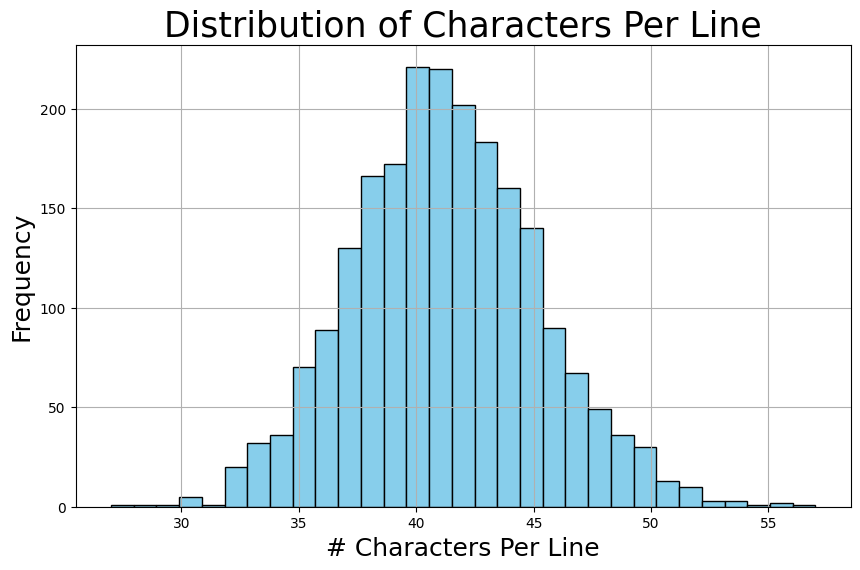

In [ ]:
# Convert character sequences to vectors
char_sequences_vectors = [[char_to_index[char] for char in sequence] for sequence in char_seqs]
pickle.dump(char_sequences_vectors, open("char_sequences_vectors.pkl", "wb"))

# Process lines and create histogram
processed_lines = [' '.join(line) for line in processed_seqs]
line_lengths = [len(line) for line in processed_lines]

num_bins = max(line_lengths) - min(line_lengths) + 1
plt.figure(figsize=(10, 6))
plt.hist(line_lengths, bins=num_bins, color='skyblue', edgecolor='black')
plt.title('Distribution of Characters Per Line', fontsize=25)
plt.xlabel('# Characters Per Line', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.grid(True)
plt.show()

In [ ]:
"""
Process the syllable dictionary
"""
def get_sylla_dic(dic_path):

    with open(dic_path, 'rb') as file:
        syllable_dict = file.read().decode('utf-8')

    syllable_dictionary = [line.split() for line in syllable_dict.split('\n') if len(line.split()) >= 2]
    for i in range(len(syllable_dictionary)):
      syllable_dictionary[i][0] = re.sub(r'[^\w]', '', syllable_dictionary[i][0]).lower() # remove all non-alpha numerical characters
      syl_dic = {}
      for pair in syllable_dictionary:
        if pair[1].isdigit(): # usual count
          syl_dic[pair[0]] = int(pair[1])
        else:
          syl_dic[pair[0]] = int(pair[2]) # We skip the end count
    return syl_dic



In [ ]:
# Load and open the dataset shakespeare
# with open('/content/shakespeare.txt', 'rb') as file:
#     shakespeare = file.read().decode('utf-8')

shakespeare = data_preprocess2('shakespeare.txt')

# Load the syllable dictionary
syl_dic = get_sylla_dic('/content/syllable_dict.txt')


# **Poetry Generation, Part 1: HMM**

# *HMM module*

In [ ]:
# You can use this skeleton code to complete the HMM
# implementation of set 5. Once each part is implemented, you can simply
# execute the related problem scripts (e.g. run 'python 2G.py') to quickly
# see the results from your code.
#
# Some pointers to get you started:
#
#     - Choose your notation carefully and consistently! Readable
#       notation will make all the difference in the time it takes you
#       to implement this class, as well as how difficult it is to debug.
#
#     - Read the documentation in this file! Make sure you know what
#       is expected from each function and what each variable is.
#
#     - Any reference to "the (i, j)^th" element of a matrix T means that
#       you should use T[i][j].
#
#     - Note that in our solution code, no NumPy was used. That is, there
#       are no fancy tricks here, just basic coding. If you understand HMMs
#       to a thorough extent, the rest of this implementation should come
#       naturally. However, if you'd like to use NumPy, feel free to.
#
#     - Take one step at a time! Move onto the next algorithm to implement
#       only if you're absolutely sure that all previous algorithms are
#       correct. We are providing you waypoints for this reason.
#
# To get started, just fill in code where indicated. Best of luck!

class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0.
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.

            D:          Number of observations.

            A:          The transition matrix.

            O:          The observation matrix.

            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]

    def save(self, filename):
        '''
        Saves the HMM to a file as a list of lists.
        .txt file
        '''
        with open (filename, 'w') as f:
            f.write(str(self.L) + '\n')
            f.write(str(self.D) + '\n')
            for row in self.A:
                f.write(' '.join(map(str, row)) + '\n')
            for row in self.O:
                f.write(' '.join(map(str, row)) + '\n')
            f.write(' '.join(map(str, self.A_start)) + '\n')

    def load(filename):
        '''
        Loads an HMM from a file.
        '''
        with open (filename, 'r') as f:
            L = int(f.readline())
            D = int(f.readline())
            A = [list(map(float, f.readline().split())) for _ in range(L)]
            O = [list(map(float, f.readline().split())) for _ in range(L)]
            A_start = list(map(float, f.readline().split()))

        hmm = HiddenMarkovModel(A, O)
        hmm.A_start = A_start
        return hmm

    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          probs[1][i] = self.A_start[i] * self.O[i][x[0]]
          seqs[1][i] = str(i)


        for d in range(2, M + 1):

          for curr_state in range(self.L):
            max_prob = float("-inf")
            best_seq = ""

            for prev_state in range(self.L):
              prob = probs[d-1][prev_state] * self.A[prev_state][curr_state] * self.O[curr_state][x[d-1]]
              if prob >= max_prob:
                max_prob = prob
                best_seq = seqs[d-1][prev_state] + str(curr_state)

            probs[d][curr_state] = max_prob
            seqs[d][curr_state] = best_seq

        max_seq = seqs[M][np.argmax(probs[M])]
        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          alphas[1][i] = self.A_start[i] * self.O[i][x[0]]

        for d in range(2, M + 1):

          for curr_state in range(self.L):
            prob = 0
            for prev_state in range(self.L):
              prob += (self.O[curr_state][x[d-1]] * (alphas[d-1][prev_state] * self.A[prev_state][curr_state]))

            alphas[d][curr_state] = prob

          if normalize:
            denom = np.sum(alphas[d])
            alphas[d] = [alpha/denom for alpha in alphas[d]]


        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          betas[M][i] = 1

        for d in range(M - 1, -1, -1):

          for curr_state in range(self.L):
            prob = 0
            for next_state in range(self.L):
                if d == 0:
                  prob += (betas[d+1][next_state] * self.A_start[next_state] * self.O[next_state][x[d]])
                else:
                  prob += (betas[d+1][next_state] * self.A[curr_state][next_state] * self.O[next_state][x[d]])

            betas[d][curr_state] = prob

          if normalize:
            denom = np.sum(betas[d])
            betas[d] = [beta/denom for beta in betas[d]]

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for prev_state in range(self.L):
          for curr_state in range(self.L):
            numer_array = []
            denom_array = []

            for x in range(len(X)):
              for y in range(1, len(Y[x])):
                if Y[x][y] == curr_state and Y[x][y-1] == prev_state:
                  numer_array.append(1)
                else:
                  numer_array.append(0)

                if Y[x][y-1] == prev_state:
                  denom_array.append(1)
                else:
                  denom_array.append(0)

            numer = np.sum(numer_array)
            denom = np.sum(denom_array)
            self.A[prev_state][curr_state] = numer/denom

        # Calculate each element of O using the M-step formulas.
        for curr_state in range(self.L):
          for curr_obs in range(self.D):
            numer_array = []
            denom_array = []

            for x in range(len(X)):
              for y in range(len(Y[x])):
                if X[x][y] == curr_obs and Y[x][y] == curr_state:
                  numer_array.append(1)
                else:
                  numer_array.append(0)

                if Y[x][y] == curr_state:
                  denom_array.append(1)
                else:
                  denom_array.append(0)

            numer = np.sum(numer_array)
            denom = np.sum(denom_array)
            self.O[curr_state][curr_obs] = numer/denom


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            N_iters:    The number of iterations to train on.
        '''

        for i in range(N_iters):
          A_numer = np.zeros((self.L, self.L))
          A_denom = np.zeros((self.L, self.L))
          O_numer = np.zeros((self.L, self.D))
          O_denom = np.zeros((self.L, self.D))

          for x in X:
            alphas = self.forward(x, normalize=True)
            betas = self.backward(x, normalize=True)
            M = len(x)

            for d in range(1, M + 1):
              prob_OAd = np.array([alphas[d][curr_state] * betas[d][curr_state] for curr_state in range(self.L)])
              prob_OAd /= np.sum(prob_OAd)

              for curr_state in range(self.L):
                O_numer[curr_state][x[d-1]] += prob_OAd[curr_state]
                O_denom[curr_state] += prob_OAd[curr_state]
                if d != M:
                  A_denom[curr_state] += prob_OAd[curr_state]

            for d in range(1, M):
              prob_An = np.array([[alphas[d][curr_state] \
                                  * self.O[next_state][x[d]] \
                                  * self.A[curr_state][next_state] \
                                  * betas[d+1][next_state] \
                                  for next_state in range(self.L)] \
                                  for curr_state in range(self.L)])
              prob_An /= np.sum(prob_An)

              for curr_state in range(self.L):
                for next_state in range(self.L):
                  A_numer[curr_state][next_state] += prob_An[curr_state][next_state]

          self.A = A_numer / A_denom
          self.O = O_numer / O_denom


    def generate_emission(self, M, seed=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random.
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        # Initialize Random Start State
        state = np.random.randint(0, self.L)

        for d in range(M):
          emission.append(np.random.choice(list(range(self.D)), p = self.O[state]))
          states.append(state)
          state = np.random.choice(list(range(self.L)), p = self.A[state])

        return emission, states


    # Generates one word
    def generate_emission_for_word(self, state=None, seed=None):

        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        # Initialize Random Start State
        if not state:
            state = np.random.randint(0, self.L)

        emission = np.random.choice(list(range(self.D)), p = self.O[state])
        state = np.random.choice(list(range(self.L)), p = self.A[state])

        return emission, state


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)

    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters, seed=None):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.

        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''
    # Initialize random number generator
    rng = np.random.default_rng(seed=seed)

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM


In [ ]:
########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################

from matplotlib.animation import FuncAnimation
from wordcloud import WordCloud

####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds

def average_syllables_emitted_by_state(hmm, obs_map, max_words=50):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    syllables = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, get the average number of syllables in the observations.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        syllable_count = sum([syl_dic[word] for word in sentence if word in syl_dic])
        syllables.append(syllable_count/len(sentence))

    return syllables

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def part_of_speech_by_state(hmm, obs_map, max_words=50):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    pos = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, get the part of speech of the observations.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        tokens = nltk.word_tokenize(sentence_str)
        pos.append(nltk.pos_tag(tokens))

    return pos

def freq_pos_by_state(pos):
    # Initialize.
    n_states = len(pos)
    pos_lst = []

    for i in range(n_states):
        pos_lst.append(Counter([j[1] for j in pos[i]]))

    return pos_lst

def average_word_length_by_state(hmm, obs_map, max_words=50):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    word_lengths = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        word_lengths.append(sum([len(word) for word in sentence])/len(sentence))

    return word_lengths


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []

        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1

            # Add the encoded word.
            obs_elem.append(obs_map[word])

        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words, seed=seed)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1, seed=None):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06

    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)

    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)

            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M, seed=seed)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:

# Shakespearean sonnets and Haikus require specific syllable numbers
# To do sentence generation with specific syllable numbers, generate_emission_for_word method is written for hmm

def sample_sentence_syllable(hmm, obs_map, syllable_length, syl_dic, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    num_syllab = 0
    sentence = []

    # For initial word
    state = None

    while num_syllab < syllable_length:
        emission, new_state = hmm.generate_emission_for_word(state=state, seed=seed)
        word = obs_map_r[emission]
        num_syllab_of_word = syl_dic[word.lower()]
        if num_syllab_of_word <= (syllable_length - num_syllab):
            sentence.append(word)
            num_syllab += num_syllab_of_word
            state = new_state

    return ' '.join(sentence).capitalize() + '...'

# *HMM Model*

In [ ]:
# Removing numbers
# shakespeare_nonumber = re.sub(r'\d+', '', shakespeare)
# Define encoder, decoder (same as HW6)
obs, obs_map = parse_observations(shakespeare)

# Train a HMM on the data
# hmm0 = unsupervised_HMM(obs, 10, 100)
# hmm0.save("hmm0.txt")


In [ ]:
# Get Model if save (hmm0 -> 20 hidden states)
hmm0 = HiddenMarkovModel.load("hmm20.txt")

In [ ]:
# To do sentence generation with specific syllable numbers, generate_emission_for_word method is written for hmm

def sample_sentence_syllable(hmm, obs_map, syllable_length, syl_dic, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    num_syllab = 0
    sentence = []

    # For initial word
    state = None

    while num_syllab < syllable_length:
        emission, state = hmm.generate_emission_for_word(state=state, seed=seed)
        word = obs_map_r[emission]
        num_syllab_of_word = syl_dic[word.lower()]
        if num_syllab_of_word <= (syllable_length - num_syllab):
            sentence.append(word)
            num_syllab += num_syllab_of_word

    return ' '.join(sentence).capitalize() + '...'

In [ ]:
def generate_sonnet():
  sonnet = ''
  sonnet_counts = ''
  syllable_length = [10]*14

  for index, line_syllables in enumerate(syllable_length):
    if index %4 == 0:
      sonnet += '\n'
      sonnet_counts += '\n'
    # Generate one sentence from the model
    sentence = sample_sentence_syllable(hmm0, obs_map, line_syllables, syl_dic, seed=None)
    # Capitalize i and o
    sentence = sentence.replace(' i ', ' I ').replace(' o ', ' O ').replace(' i...', ' I...')
    # clean_sentence = []
    # Keep count on the number of syllables
    num_syllab = 0
    for word in sentence[:-3].split():
      if word.lower() in syl_dic:
        num_syllab += syl_dic[word.lower()] # adds number of syllables

      # # Capitalize i and o
      # if word == 'i' or word == 'o':
      #   clean_sentence.append(word.capitalize())
      # elif word == 'i...' or word == 'o...':
      #   clean_sentence.append(word[:-1].capitalize() + ',')
      # else:
      #   clean_sentence.append(word)

    # sentence = ' '.join(clean_sentence)
    sonnet_counts += sentence[:-3] + '  ' + f'(number of Syllables = {num_syllab})' + ',\n'
    sonnet += sentence[:-3] + ',\n'

    return sonnet

In [ ]:
# Generate a 14-line Shaksperian sonnets
sonnet = generate_sonnet()

# Print the sonnet without syllable count

print(sonnet)


Do bring yellow untainted poor scarlet,
Which grow therefore her farther me never,
And can though deserts from for not that drugs,
Pine dark elements find even the worlds face,

In recured injurious not I come how,
Must have her though hours not by not gay made,
Knows that unions death he acquainted out,
Bring none thou shouldst both thee key and stands now,

Dost thou survive eyes doth truth and hadst to,
Me sweet is blessed subject was to their,
Words and enough that have it I am for,
As up monument is and must fade we,

Forfeit thou form and with the east harvest,
Before now you they they mine in purpose,



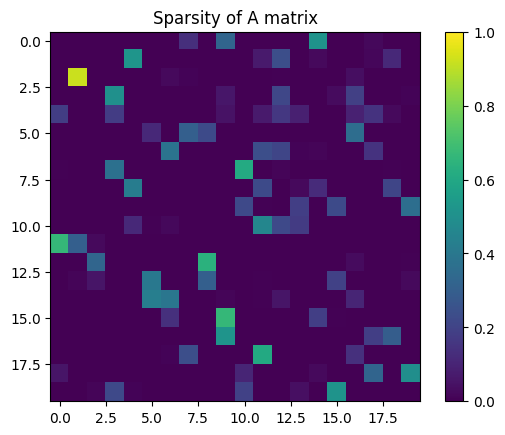

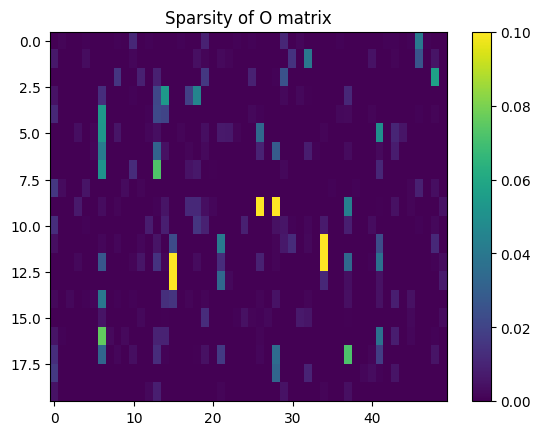

In [ ]:
visualize_sparsities(hmm0)

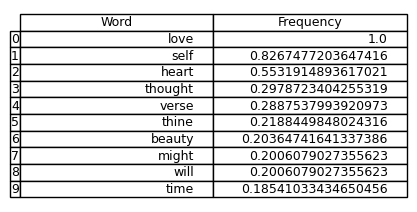

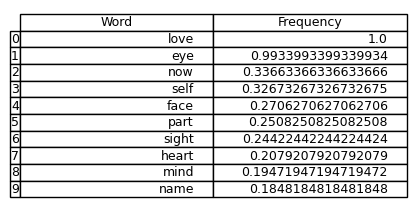

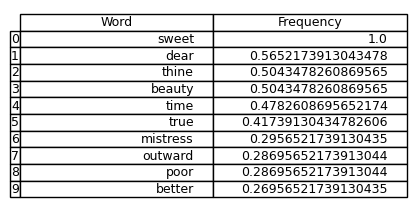

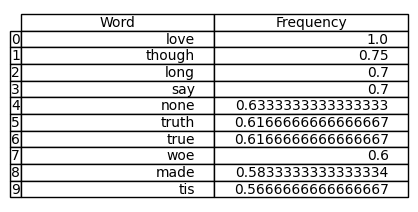

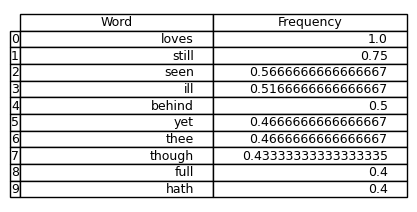

In [ ]:
# Top 10 words for each state
wordclouds = states_to_wordclouds(hmm0, obs_map, max_words=20, show=False)

top_words = []
for i in range(len(wordclouds)):
    top_words.append(wordclouds[i].words_)

import pandas as pd
from pandas.plotting import table

dfs = []
for i in range(5):
    df = pd.DataFrame(list(top_words[i].items()),columns = ['Word','Frequency'])
    df = df.sort_values(by='Frequency', ascending=False)
    df = df.reset_index(drop=True)
    dfs.append(df.head(10))

for i in range(5):
    fig, ax = plt.subplots(figsize=(5, 2.5))
    table(ax, dfs[i], loc='center')
    ax.set_axis_off()
    plt.show()


Animating...


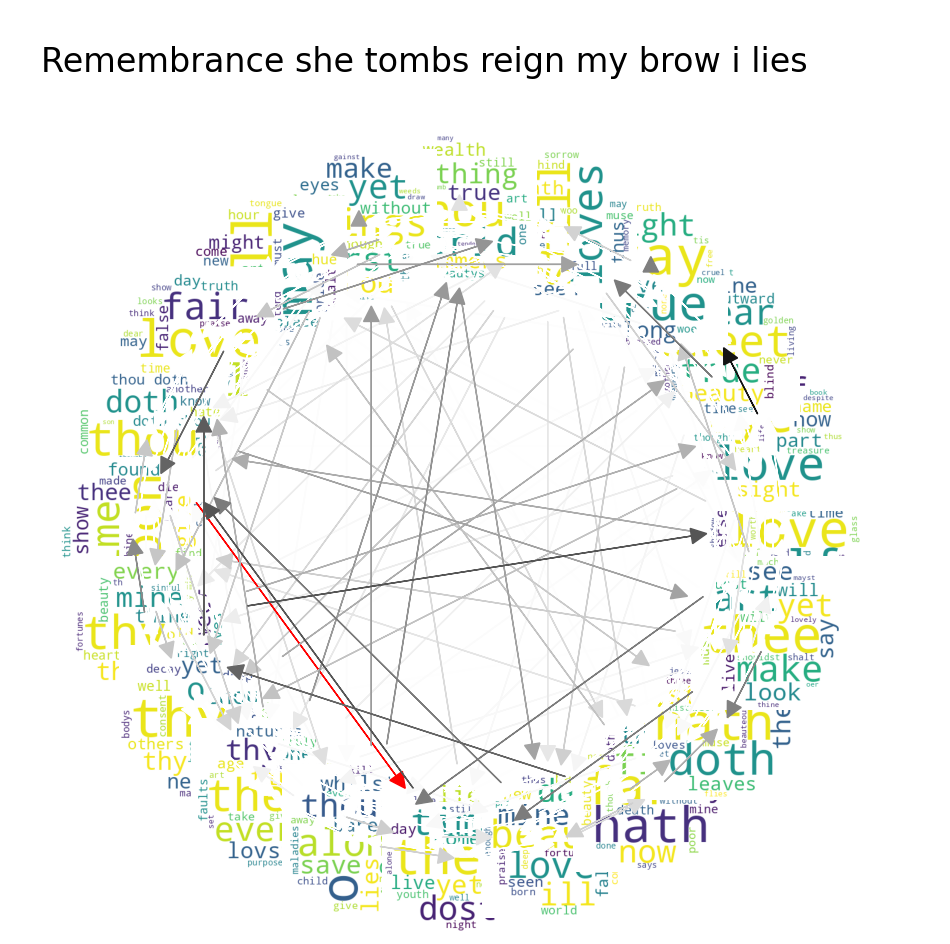

In [ ]:
anim = animate_emission(hmm0, obs_map, M=8, height=12, width=12, delay=1, seed=0)
anim.save('hmm020.gif', writer='imagemagick', fps=1)

In [ ]:
!sudo apt-get install graphviz graphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jamm

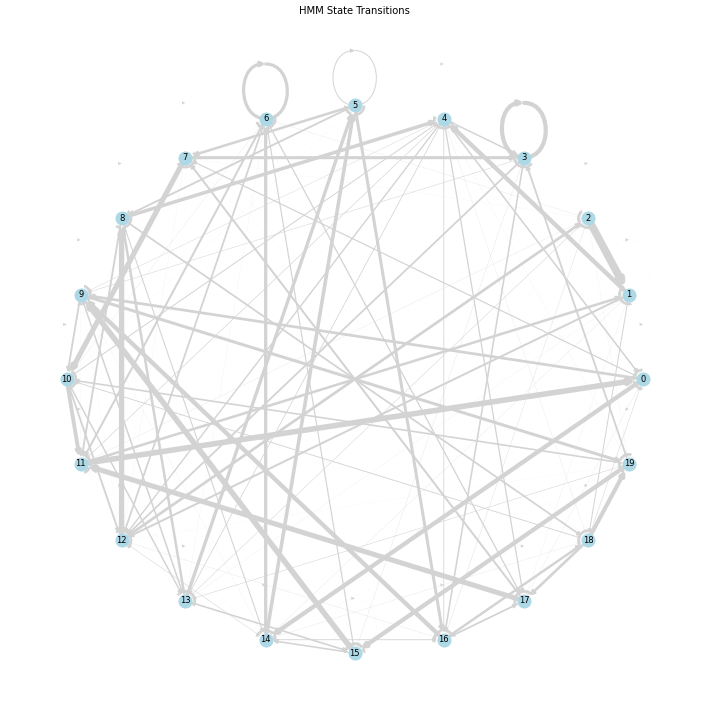

In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()
transition_matrix = hmm0.A
obs_map_r = obs_map_reverser(obs_map)
observation_matrix = hmm0.O

# Add nodes
for i in range(len(transition_matrix)):
    G.add_node(i, label=obs_map_r[i])

# Add edges
for i in range(len(transition_matrix)):
    for j in range(len(transition_matrix[i])):
        G.add_edge(i, j, weight=transition_matrix[i][j])

# Draw the graph
# pos = graphviz_layout(G, prog='dot')
# pos = nx.spring_layout(G, pos=pos, fixed=[0, 1])

pos = nx.circular_layout(G, scale=10)
fig = plt.figure(1, figsize=(15, 15), dpi=60)
# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=250)

# Draw the edges
edges = G.edges()
weights = [G[u][v]['weight'] * 10 for u,v in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='lightgrey', width=weights, arrowsize=10)

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# edge_labels = {(i, j): round(transition_matrix[i][j], 2) for i, j in G.edges()}
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

# Show the graph
plt.title('HMM State Transitions')
plt.axis('off')
plt.show()

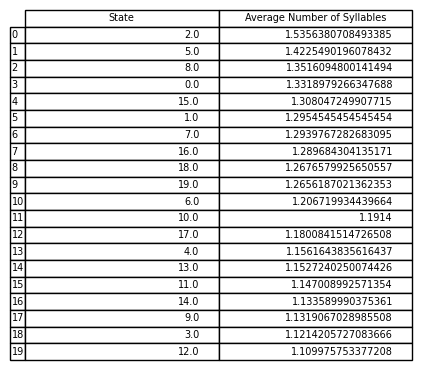

In [ ]:
syllable_avg = average_syllables_emitted_by_state(hmm0, obs_map, max_words=50)

import pandas as pd
df = pd.DataFrame({'State': list(range(20)), 'Average Number of Syllables': syllable_avg})
df = df.sort_values(by='Average Number of Syllables', ascending=False)
df = df.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5, 2.5))
table(ax, df, loc='center')
ax.set_axis_off()
plt.show()

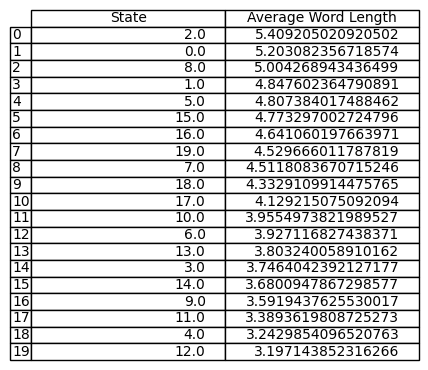

In [ ]:
# average word length by state
word_length_avg = average_word_length_by_state(hmm0, obs_map, max_words=50)

import pandas as pd
df = pd.DataFrame({'State': list(range(20)), 'Average Word Length': word_length_avg})
df = df.sort_values(by='Average Word Length', ascending=False)
df = df.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5, 2.5))
table(ax, df, loc='center')
ax.set_axis_off()
plt.show()

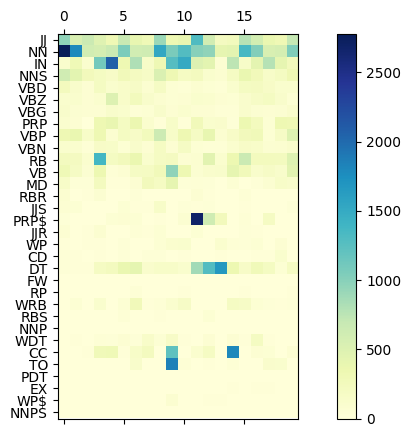

In [ ]:
# pos by state
pos = part_of_speech_by_state(hmm0, obs_map, max_words=50)
pos_avg = freq_pos_by_state(pos)

import pandas as pd

df = pd.DataFrame(pos_avg)
df = df.fillna(0)
df = df.T

fig, ax = plt.subplots(figsize=(10, 5))
cax = ax.matshow(df, cmap='YlGnBu')
fig.colorbar(cax)

ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df.index)

plt.show()

In [ ]:
!pip install -qU prosodic

# install espeak to pronounce unknown words
!apt-get -qq install espeak > /dev/null

# check espeak installed
!which espeak

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
/usr/bin/espeak


In [ ]:
import prosodic as p
# p.config['print_to_screen']=0

def stresses(hmm, obs_map, max_words=50):
    # Initialize.
    M = 10000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    stress_states = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)
        # for j in range(len(sentence)):
        #     if j % 10 == 0 and j != 0:
        #         sentence_str += "\n"

        #     sentence_str += sentence[j] + " "

        # sentence_str = sentence_str[:-1]
        text = p.Line(sentence_str)
        text_p = text.parse()
        w_cnt = 0
        s_cnt = 0
        cnter = Counter()
        line = text_p[0]
        for i in line:
            cnter[i.meter_val] += 1

        stress_states.append(cnter)
    return stress_states

In [ ]:
stress_states = stresses(hmm0, obs_map, max_words=20)

import pandas as pd
df = pd.DataFrame(stress_states, columns = ['Number of Weak Stress', 'Number of Strong Stress'])
df = df.fillna(0)
df = df.T

fig, ax = plt.subplots(figsize=(10, 5))
cax = ax.matshow(df, cmap='YlGnBu')
fig.colorbar(cax)

ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df.index)

plt.show()

⎾ tokenizing @ 2024-03-09 04:08:48,091
⎿ 0 seconds @ 2024-03-09 04:08:48,119
⎾ parsing text Line(txt='sword better self winter birth view relief self end more blot madness head chest not heart thoughts more summer shadow love mind more skill enemies delight pride brass good self soul blunt self birds shadow heart help lines state nought picture compare red star control yours vows soul state self looks heart pride desert merits repay beauty self self lived art desert self love erred sword feathers slave will fears skill here cries men self slain more heart verse bright heart sooner birth pride love pain patent eye worthless bereft bright sake sooner end heart heart state help figure art trust thought compare love self will age deaths worth prescriptions love dearest wealth adjunct brow matter love wronk much unkind hate creation love odour service mistress black youth delight flies mind thine ye heart state conquest skill such thine foul star records rose oblation might alchemy bright r

In [ ]:
hmm1 = unsupervised_HMM(obs, 20, 100)

# **Poetry Generation, Part 2: Recurrent Neural Networks**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM, Lambda, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
import numpy as np

In [ ]:
# Load preprocessed character-based sequence vectors and dictionaries for character encoding
char_sequence_vectors = pickle.load(open("char_sequences_vectors.pkl", "rb"))
char_to_idx = pickle.load(open("char_to_index.pkl", "rb"))

"""
Prepares the dataset for training the RNN model
"""
def prepare_dataset(sequence_vectors, char_encoding_map):
    # Convert sequence vectors to a numpy array for manipulation
    sequence_vectors = np.array(sequence_vectors)
    # Extract inputs (X) and target outputs (Y) from sequence vectors
    inputs, targets = sequence_vectors[:, :-1], sequence_vectors[:, -1]

    # One-hot encode the input sequences and targets
    X = np.array([to_categorical(input_seq, num_classes=len(char_encoding_map)) for input_seq in inputs])
    Y = to_categorical(targets, num_classes=len(char_encoding_map))

    return X, Y

train_inputs, train_targets = prepare_dataset(char_sequence_vectors, char_to_idx)


In [ ]:
"""
Define Model
"""
model = Sequential()
# Set size of LSTM layer (100-200 LSTM units)
hidden_units = 200
# Add LSTM layer
model.add(LSTM(hidden_units, input_shape=(train_inputs.shape[1], train_inputs.shape[2])))
# Append a fully-connected output layer
model.add(Dense(len(char_to_idx), activation='softmax'))
# Minimizing cross entropy with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Visualize model architecture and save
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               184000    
                                                                 
 dense (Dense)               (None, 29)                5829      
                                                                 
Total params: 189829 (741.52 KB)
Trainable params: 189829 (741.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(train_inputs, train_targets, batch_size=128, epochs=60)

Epoch 1/50
711/711 [==============================] - 129s 177ms/step - loss: 2.4151 - accuracy: 0.3072
Epoch 2/50
711/711 [==============================] - 127s 179ms/step - loss: 2.0434 - accuracy: 0.3946
Epoch 3/50
711/711 [==============================] - 128s 179ms/step - loss: 1.8989 - accuracy: 0.4312
Epoch 4/50
711/711 [==============================] - 126s 178ms/step - loss: 1.7930 - accuracy: 0.4600
Epoch 5/50
711/711 [==============================] - 126s 177ms/step - loss: 1.7141 - accuracy: 0.4779
Epoch 6/50
711/711 [==============================] - 127s 178ms/step - loss: 1.6499 - accuracy: 0.4932
Epoch 7/50
711/711 [==============================] - 126s 177ms/step - loss: 1.5950 - accuracy: 0.5072
Epoch 8/50
711/711 [==============================] - 126s 177ms/step - loss: 1.5493 - accuracy: 0.5211
Epoch 9/50
711/711 [==============================] - 126s 177ms/step - loss: 1.5055 - accuracy: 0.5310
Epoch 10/50
711/711 [==============================] - 125s 176m

KeyboardInterrupt: 

In [ ]:
model = load_model('rnn_model.h5')

In [ ]:
"""
Generates a list of models for different temperatures, which controls variance of the sampled text.
"""
# def create_temperature_scaled_models(orig_model, lstm_units, input_data, char_to_index_map, temp_values):
#     # Extract weights from the original model
#     weights_list = [layer_weights.get_weights() for layer_weights in orig_model.layers]

#     models_with_temperature = []
#     for temperature in temp_values:
#         # Define a new model architecture with temperature scaling
#         temp_adjusted_model = Sequential([
#         LSTM(lstm_units, input_shape=(input_data.shape[1], input_data.shape[2])),
#         Lambda(lambda y: y / temperature),
#         Dense(len(char_to_index_map), activation='softmax')
#         ])
#         temp_adjusted_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#         # Apply original weights to the newly defined model
#         temp_adjusted_model.layers[0].set_weights(weights_list[0])
#         temp_adjusted_model.layers[2].set_weights(weights_list[1])

#         models_with_temperature.append(temp_adjusted_model)

#     return models_with_temperature

def temp_predict(model, encoded_chars, temp):
  m1 = Sequential(model.layers[:1])
  m2 = Sequential(model.layers[1:])

  def lambda_layer(z):
    return z / temp

  prediction = m2(lambda_layer(m1(encoded_chars)))
  return prediction

In [ ]:
# Playing around with temperatures T > 1 and T < 1
temperatures = [1.5, 0.5, 3, 0.25, 1]
hidden_units = 200
train_inputs, train_targets = prepare_dataset(char_sequence_vectors, char_to_idx)


# scaled_models = create_temperature_scaled_models(model, hidden_units, train_inputs,
#                                                  char_to_index, temperatures)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

median_line_length = 40  # Aiming for a median line length
total_lines = 14
line_lengths = np.random.normal(median_line_length, 5, size=total_lines).astype(int)

def compose_poetry(temp, char_to_index, input_shape, starting_phrase, total_lines, line_lengths):
    # Initialize the poem with the starting phrase capitalized
    poem_lines = [starting_phrase.capitalize()]

    # Compose the remaining lines of the poem
    for _ in range(total_lines - 1):
        current_line = ''
        for _ in range(line_lengths[_]):
            encoded_chars = [char_to_index[char] for char in starting_phrase]
            encoded_chars = pad_sequences([encoded_chars], maxlen=input_shape.shape[1], truncating='pre')
            encoded_chars = to_categorical(encoded_chars, num_classes=len(char_to_index))

            # Predict next character's index
            # next_char_index = model.predict(encoded_chars, verbose=0).argmax(axis=1)
            next_char_index = temp_predict(model, encoded_chars, temp).numpy().argmax(axis=1)

            # Convert index back to character and update starting phrase
            for char, index in char_to_index.items():
                if index == next_char_index:
                    starting_phrase += char
                    current_line += char
                    break

        # Prepare starting phrase for the next iteration
        starting_phrase = ' '.join(starting_phrase.split(' ')[:-1])
        current_line = ' '.join(current_line.split(' ')[:-1])

        # Append processed line to poem
        poem_lines.append(current_line.strip().capitalize())

    # If i or o are alone, capitalizes them as it should
    for idx, line in enumerate(poem_lines):
        prettied_line = line.replace(' i ', ' I ').replace(' o ', ' O ')

        # Adjust for every fourth line for the 3 quatrains (section with 4 lines)
        if idx % 4 == 0 and idx != 0:
            print()

        print(prettied_line)

# Generating 14-line sonnets for different temperatures
for idx, temperature in enumerate(temperatures):
    print(f'Generated poem for temperature = {temperature}')
    print('-------------------------------------------------------')
    compose_poetry(temperature, char_to_idx, train_inputs,
                   "shall i compare thee to a summer's day",total_lines, line_lengths)
    print()


Generated poem for temperature = 1.5
-------------------------------------------------------


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'argmax'

# **Additional Goals**

## **Incorporating additional texts**

In [ ]:
# Load and open the dataset shakespeare
with open('/content/shakespeare.txt', 'rb') as file:
    shakespeare = file.read().decode('utf-8')
with open('/content/spenser.txt', 'rb') as file:
    spenser = file.read().decode('utf-8')
# Load the syllable dictionary
syl_dic = get_sylla_dic('/content/syllable_dict.txt')

# Function to clean roman numbers from text using regular expressions.
# Taken from https://stackoverflow.com/a/68050802/15405769
def clean(text):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    return re.sub(pattern, '', text)

shakespeare_nonumber = re.sub(r'\d+', '', shakespeare)
spenser_nonumber = clean(spenser)

shakespeare_spenser_nonumber = shakespeare_nonumber + '\n' + spenser_nonumber

In [ ]:
# Define encoder, decoder (same as HW6)
obs, obs_map = parse_observations(shakespeare_spenser_nonumber)


# Train a HMM on the data
hmm_shakespeare_spenser20 = unsupervised_HMM(obs, 20, 100)
hmm_shakespeare_spenser20.save("hmm_shakespeare_spenser20.txt")

In [ ]:
! pip install syllapy

In [ ]:
obs, obs_map = parse_observations(shakespeare_spenser_nonumber)

In [ ]:
# Generate sonnet without updating syllable dictionary with the words that are in spenser but not in shakespeare
# Generate a 14-line sonnet
sonnet = ''
sonnet_counts = ''
for line in range(14):
  if line %4 == 0:
    sonnet += '\n'
    sonnet_counts += '\n'
  # Generate one sentence from the model
  sentence = sample_sentence_syllable(hmm_shakespeare_spenser20, obs_map, 10, syl_dic_both)
  # Capitalize i and o
  # Keep count on the number of syllables
  num_syllab = 0
  for word in sentence[:-3].split():
    if word.lower() in syl_dic:
      num_syllab += syl_dic[word.lower()] # adds number of syllables

  sentence = sentence.replace(' i ', ' I ').replace(' o ', ' O ').replace(' i...', ' I...')

  sonnet_counts += sentence[:-3] + '  ' + f'(number of Syllables = {num_syllab})' + ',\n'
  sonnet += sentence[:-3] + ',\n'

# Print the sonnet without syllable count

print(sonnet)
print(sonnet_counts)

In [ ]:
# Updating the syllable dict because the current one doesn't have the words that are in spenser but not in shakespeare
# syllapy is not perfect, ongoing project
import syllapy

shakespeare_processed_text = data_preprocess2('shakespeare.txt')
set_shakespeare = set(shakespeare_processed_text.split())
spenser_processed_text = data_preprocess2('spenser.txt')
set_spenser = set(spenser_processed_text.split())

set_difference = set_spenser - set_shakespeare

syl_dic_difference = {}
for w in set_difference:
    syl_dic_difference[w] = syllapy.count(w)

syl_dic_both = get_sylla_dic('/content/syllable_dict.txt')
syl_dic_both.update(syl_dic_difference)

In [ ]:
# Generate a sonnet with the updated syllable dictionary
# Generate a 14-line sonnet
sonnet = ''
sonnet_counts = ''
for line in range(14):
  if line %4 == 0:
    sonnet += '\n'
    sonnet_counts += '\n'
  # Generate one sentence from the model
  sentence = sample_sentence_syllable(hmm_shakespeare_spenser20, obs_map, 10, syl_dic_both)
  # Capitalize i and o
  # Keep count on the number of syllables
  num_syllab = 0
  for word in sentence[:-3].split():
    if word.lower() in syl_dic_both:
      num_syllab += syl_dic_both[word.lower()] # adds number of syllables

  sentence = sentence.replace(' i ', ' I ').replace(' o ', ' O ').replace(' i...', ' I...')

  sonnet_counts += sentence[:-3] + '  ' + f'(number of Syllables = {num_syllab})' + ',\n'
  sonnet += sentence[:-3] + ',\n'

# Print the sonnet without syllable count

print(sonnet)
print(sonnet_counts)

## **Generating other poetic forms**

In [ ]:
# Haiku generation requires specific syllable numbers
# To do sentence generation with specific syllable numbers, generate_emission_for_word method is written for hmm

def sample_sentence_syllable(hmm, obs_map, syllable_length, syl_dic, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    num_syllab = 0
    sentence = []

    # For initial word
    state = None

    while num_syllab < syllable_length:
        emission, new_state = hmm.generate_emission_for_word(state=state, seed=seed)
        word = obs_map_r[emission]
        num_syllab_of_word = syl_dic[word.lower()]
        if num_syllab_of_word <= (syllable_length - num_syllab):
            sentence.append(word)
            num_syllab += num_syllab_of_word
            state = new_state

    return ' '.join(sentence).capitalize() + '...'


In [ ]:
hmm_shakespeare_spenser20 = HiddenMarkovModel.load("hmm_shakespeare_spenser20.txt")
hmm_shakespeare_spenser10 = HiddenMarkovModel.load("hmm_shakespeare_spenser10.txt")
hmm_shakespeare20 = HiddenMarkovModel.load("hmm_shakespeare20.txt")
hmm_shakespeare10 = HiddenMarkovModel.load("hmm_shakespeare10.txt")

In [ ]:
# Haiku generation with shakespeare + spenser
# Haiku generation: 3 lines with syllables for each line as follows: 5/7/5
lines_syllables = [5, 7, 5]
sonnet = ''
sonnet_counts = ''
n_words = 7
for line_syllables in lines_syllables:
  # Generate one sentence from the model
  sentence = sample_sentence_syllable(hmm_shakespeare_spenser20, obs_map, line_syllables, syl_dic_both)
  # Keep count on the number of syllables
  num_syllab = 0
  for word in sentence[:-3].split():
    if word.lower() in syl_dic_both:
      num_syllab += syl_dic_both[word.lower()] # adds number of syllables

  # Capitalize i and o
  sentence = sentence.replace(' i ', ' I ').replace(' o ', ' O ').replace(' i...', ' I...')

  sonnet_counts += sentence[:-3] + '  ' + f'(number of Syllables = {num_syllab})' + ',\n'
  sonnet += sentence[:-3] + ',\n'

print(sonnet_counts)

Vouchsafe from my and  (number of Syllables = 5),
Stare your passion true dismayed  (number of Syllables = 7),
Fair which year apply  (number of Syllables = 5),



In [ ]:
# Define encoder, decoder (same as HW6)
obs, obs_map = parse_observations(shakespeare_nonumber)


# Train a HMM on the data
hmm_shakespeare10 = unsupervised_HMM(obs, 10, 100)
hmm_shakespeare10.save("hmm_shakespeare10.txt")

In [ ]:
# Haiku generation with just shakespeare
# Haiku generation: 3 lines with syllables for each line as follows: 5/7/5
lines_syllables = [5, 7, 5]
sonnet = ''
sonnet_counts = ''
n_words = 7
for line_syllables in lines_syllables:
  # Generate one sentence from the model
  sentence = sample_sentence_syllable(hmm_shakespeare10, obs_map, line_syllables, syl_dic)
  # Keep count on the number of syllables
  num_syllab = 0
  for word in sentence[:-3].split():
    if word.lower() in syl_dic:
      num_syllab += syl_dic[word.lower()] # adds number of syllables

  # Capitalize i and o
  sentence = sentence.replace(' i ', ' I ').replace(' o ', ' O ').replace(' i...', ' I...')

  sonnet_counts += sentence[:-3] + '  ' + f'(number of Syllables = {num_syllab})' + ',\n'
  sonnet += sentence[:-3] + ',\n'

print(sonnet_counts)

Thou is to fire be  (number of Syllables = 5),
There art found they which convert  (number of Syllables = 7),
Proud thine thief didst way  (number of Syllables = 5),

